In [112]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import akshare as ak
import json
import os
import time
import sqlite3

from datetime import datetime, timedelta
from tqdm import tqdm
from database.downloader.downloader_base import DownloaderBase
import database.database_config as db_config

pd.options.display.max_rows=None
pd.options.display.max_columns=None

In [113]:
db_conn = sqlite3.connect('../database/hh_quant.db')
db_downloader = DownloaderBase(db_conn, db_config)

In [121]:
# stock_code_list = ak.stock_info_a_code_name()['code'] # 获取A股所有股票列表
# stock_code_list = ak.index_stock_cons("000016")['品种代码'].tolist() # 获取中证50的股票代码列表
stock_code_list = set(ak.index_stock_cons("000300")['品种代码'].tolist()) # 获取沪深300的股票代码列表

# 获取所有股票列表
# stock_code_list = set(db_downloader._download_stock_base_info()['stock_code'])

In [122]:
def build_label(dataframe):
    N = 5
    df = dataframe.copy()
    # 标签构建
    df['close_N_min'] = df['close'].rolling(window=N).min().shift(-N)
    df['close_N_max'] = df['close'].rolling(window=N).max().shift(-N)
    df['max_return'] = df['close_N_max'] / df['open'].shift(-1) - 1 # 计算5日间最大收益率
    df['min_return'] = df['close_N_min'] / df['open'].shift(-1) - 1 # 计算5日间最小收益率
    # 极值处理
    df['max_return'] = np.clip(df['max_return'], np.nanquantile(df['max_return'], 0.01), np.nanquantile(df['max_return'], 0.99))
    df['min_return'] = np.clip(df['min_return'], np.nanquantile(df['min_return'], 0.01), np.nanquantile(df['min_return'], 0.99))
    # 过滤一字涨停情况
    df = df[df['high'].shift(-1) != df['low'].shift(-1)]
    return df[['datetime', 'max_return', 'min_return']]

stock_df_list = []
for stock_code in tqdm(stock_code_list):
    stock_data = db_downloader._download_stock_history_info(stock_code)
    stock_label = build_label(stock_data)
    stock_factor_date = db_downloader._download_stock_factor_date_info()
    stock_factor_qlib = db_downloader._download_stock_factor_qlib_info(stock_code)
    stock_df = stock_data.merge(stock_label, on=['datetime']).merge(stock_factor_date, on=['datetime']).merge(stock_factor_qlib, on=['stock_code', 'datetime'])
    stock_df = stock_df.dropna()
    if not stock_df.empty:
        stock_df_list.append(stock_df)

print(stock_df_list)

100%|██████████| 284/284 [02:16<00:00,  2.08it/s]


In [ ]:
df = pd.concat(stock_df_list)
# print([i for i in df.columns])

['stock_code', 'stock_name', 'stock_adjust', 'datetime', 'open', 'close', 'high', 'low', 'volume', 'turnover', 'amplitude', 'change_pct', 'change_amount', 'turnover_rate', 'max_return', 'min_return', 'weekday', 'day_of_week', 'day_of_month', 'month', 'season', 'KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'OPEN1', 'OPEN2', 'OPEN3', 'OPEN4', 'HIGH0', 'HIGH1', 'HIGH2', 'HIGH3', 'HIGH4', 'LOW0', 'LOW1', 'LOW2', 'LOW3', 'LOW4', 'CLOSE0', 'CLOSE1', 'CLOSE2', 'CLOSE3', 'CLOSE4', 'VOLUME0', 'VOLUME1', 'VOLUME2', 'VOLUME3', 'VOLUME4', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 

## 使用Tensorflow

In [15]:
# 使用tensorflow处理原始数据
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)

2024-03-05 14:02:30.533659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


In [42]:
def transfer_data_type(df, columns, dtype):
    for col in columns:
        df[col] = df[col].astype(dtype)
    return df

def get_numeric_boundaries(series, num_bins=20):
    if series.nunique() < num_bins:
        boundaries = sorted(series.unique())
    else:
        boundaries = pd.qcut(series, num_bins, retbins=True, duplicates='drop')[1].tolist()
    return boundaries

In [43]:
TARGET_FEATURE_NAME = ["max_return", "min_return"]

NUMERIC_FEATURES = ['KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'OPEN1', 'OPEN2', 'OPEN3', 'OPEN4', 'HIGH0', 'HIGH1', 'HIGH2', 'HIGH3', 'HIGH4', 'LOW0', 'LOW1', 'LOW2', 'LOW3', 'LOW4', 'CLOSE0', 'CLOSE1', 'CLOSE2', 'CLOSE3', 'CLOSE4', 'VOLUME0', 'VOLUME1', 'VOLUME2', 'VOLUME3', 'VOLUME4', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'TSRANK5', 'TSRANK10', 'TSRANK20', 'TSRANK30', 'TSRANK60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', 'IMIN5', 'IMIN10', 'IMIN20', 'IMIN30', 'IMIN60', 'IMXD5', 'IMXD10', 'IMXD20', 'IMXD30', 'IMXD60', 'CORR5', 'CORR10', 'CORR20', 'CORR30', 'CORR60', 'CORD5', 'CORD10', 'CORD20', 'CORD30', 'CORD60', 'CNTP5', 'CNTP10', 'CNTP20', 'CNTP30', 'CNTP60', 'CNTN5', 'CNTN10', 'CNTN20', 'CNTN30', 'CNTN60', 'CNTD5', 'CNTD10', 'CNTD20', 'CNTD30', 'CNTD60', 'SUMP5', 'SUMP10', 'SUMP20', 'SUMP30', 'SUMP60', 'SUMN5', 'SUMN10', 'SUMN20', 'SUMN30', 'SUMN60', 'SUMD5', 'SUMD10', 'SUMD20', 'SUMD30', 'SUMD60', 'VMA5', 'VMA10', 'VMA20', 'VMA30', 'VMA60', 'VSTD5', 'VSTD10', 'VSTD20', 'VSTD30', 'VSTD60', 'WVMA5', 'WVMA10', 'WVMA20', 'WVMA30', 'WVMA60', 'VSUMP5', 'VSUMP10', 'VSUMP20', 'VSUMP30', 'VSUMP60', 'VSUMN5', 'VSUMN10', 'VSUMN20', 'VSUMN30', 'VSUMN60', 'VSUMD5', 'VSUMD10', 'VSUMD20', 'VSUMD30', 'VSUMD60']
df = transfer_data_type(df, NUMERIC_FEATURES, 'float32')
NUMERIC_FEATURES_WITH_BOUNDARIES = {k: get_numeric_boundaries(df[k])  for k in NUMERIC_FEATURES}

INTEGER_CATEGORICAL_FEATURES = ['weekday', 'day_of_month', 'month']
df = transfer_data_type(df, INTEGER_CATEGORICAL_FEATURES, 'int64')
INTEGER_CATEGORICAL_FEATURES_WITH_VOCAB = {k: df[k].unique() for k in INTEGER_CATEGORICAL_FEATURES}

STRING_CATEGORICAL_FEATURES = ['day_of_week', 'season']
df = transfer_data_type(df, STRING_CATEGORICAL_FEATURES, 'string')
STRING_CATEGORICAL_FEATURES_WITH_VOCAB = {k: df[k].unique() for k in STRING_CATEGORICAL_FEATURES}

FEATURE_NAMES = NUMERIC_FEATURES + INTEGER_CATEGORICAL_FEATURES + STRING_CATEGORICAL_FEATURES

In [44]:
# 6. 选择固定时间区间的数据
train_start_date = pd.to_datetime('2010-01-01')
train_end_date = pd.to_datetime('2019-12-31')
val_start_date = pd.to_datetime('2020-01-01')
val_end_date = pd.to_datetime('2020-12-31')

train_data = df[(pd.to_datetime(df['datetime']) >= train_start_date) & (pd.to_datetime(df['datetime']) <= train_end_date)]
validation_data = df[(pd.to_datetime(df['datetime']) >= val_start_date) & (pd.to_datetime(df['datetime']) <= val_end_date)]

print(f"train_data_size: {train_data.shape}")
print(f"validation_data_size: {validation_data.shape}")

train_data_size: (2361, 200)
validation_data_size: (243, 200)


In [45]:
def df_to_dataset(dataframe, feature_cols, label_cols, shuffle=True, batch_size=32):
  features = dataframe[feature_cols]
  labels = dataframe[label_cols]
  ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

train_ds = df_to_dataset(train_data, FEATURE_NAMES, TARGET_FEATURE_NAME, shuffle=True)
val_ds = df_to_dataset(validation_data, FEATURE_NAMES, TARGET_FEATURE_NAME, shuffle=False)

In [46]:
class Senet(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=3, seed=1024, **kwargs):
        super(Senet, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        self.seed = seed  

    def build(self, input_shape):
        self.field_size = len(input_shape)
        self.reduction_size = max(1, self.field_size // self.reduction_ratio)
        self.scale_layer = tf.keras.layers.Dense(units=self.reduction_size, activation='relu')
        self.expand_layer = tf.keras.layers.Dense(units=self.field_size, activation='relu')
        super(Senet, self).build(input_shape)

    def call(self, inputs, training=None):
        inputs = [tf.expand_dims(i, axis=1) for i in inputs]
        inputs = tf.concat(inputs, axis=1) # [B, N, dim]
        Z = tf.reduce_mean(inputs, axis=-1) # [B, N]
        A_1 = self.scale_layer(Z) # [B, X]
        A_2 = self.expand_layer(A_1) # [B, N]
        scale_inputs = tf.multiply(inputs, tf.expand_dims(A_2, axis=-1))
        output = scale_inputs + inputs # skip-connection
        return output # [B, N, dim]


class Dnn(tf.keras.layers.Layer):
    def __init__(self, hidden_units, activation="relu", dropout_rate=0.2, use_bn=False, seed=1024, **kwargs):
        super(Dnn, self).__init__(**kwargs)
        self.hidden_units = hidden_units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        self.seed = seed
        self.dense_layers = []
        self.dropout_layers = []
        self.bn_layers = []
        
    def build(self, input_shape):
        for units in self.hidden_units:
            self.dense_layers.append(tf.keras.layers.Dense(units=units, activation=self.activation))
            self.dropout_layers.append(tf.keras.layers.Dropout(rate=self.dropout_rate, seed=self.seed))
            if self.use_bn:
                self.bn_layers.append(tf.keras.layers.BatchNormalization())
        super(Dnn, self).build(input_shape)  # Be sure to call this at the end
    
    def call(self, inputs, training=False):
        x = inputs
        for i in range(len(self.hidden_units)):
            x = self.dense_layers[i](x)
            if self.use_bn:
                x = self.bn_layers[i](x, training=training)
            x = self.dropout_layers[i](x, training=training)
        return x

In [47]:
class QuantModel(tf.keras.Model):
	def __init__(self, config, **kwargs):
		super(QuantModel, self).__init__(**kwargs)
		self.config = config

		# 添加属性来存储预定义的层
		self.lookup_layers = {}
		self.embedding_layers = {}

        # 创建连续特征的离散化层和嵌入层
		for feature_name, boundaries in self.config.get("numeric_features_with_boundaries").items():
			self.lookup_layers[feature_name] = tf.keras.layers.Discretization(bin_boundaries=boundaries, output_mode='int', name=f'{feature_name}_lookup')
			self.embedding_layers[feature_name] = tf.keras.layers.Embedding(input_dim=len(boundaries) + 1, output_dim=self.config.get("feature_embedding_dims", 6), name=f'{feature_name}_embedding')
        # 创建整数特征的查找层和嵌入层
		for feature_name, vocab in self.config.get("integer_categorical_features_with_vocab").items():
			self.lookup_layers[feature_name] = tf.keras.layers.IntegerLookup(vocabulary=vocab, name=f'{feature_name}_lookup')
			self.embedding_layers[feature_name] = tf.keras.layers.Embedding(input_dim=len(vocab) + 1, output_dim=self.config.get("feature_embedding_dims", 6), name=f'{feature_name}_embedding')
		# 创建字符串特征的查找层和嵌入层
		for feature_name, vocab in self.config.get("string_categorical_features_with_vocab").items():
			self.lookup_layers[feature_name] = tf.keras.layers.StringLookup(vocabulary=vocab, name=f'{feature_name}_lookup')
			self.embedding_layers[feature_name] = tf.keras.layers.Embedding(input_dim=len(vocab) + 1, output_dim=self.config.get("feature_embedding_dims", 6), name=f'{feature_name}_embedding')

		self.senet_layer = Senet(
			reduction_ratio=self.config.get('reduction_ratio', 3), 
			seed=self.config.get('seed', 1024),
		)
		self.dnn_layer = Dnn(
			hidden_units=self.config.get('dnn_hidden_units', [64,32]),
			activation=self.config.get('dnn_activation', 'relu'),
			dropout_rate=self.config.get('dnn_dropout', 0.2),
			use_bn=self.config.get('dnn_use_bn', True)
		)
		self.output_layer_1 = tf.keras.layers.Dense(1, activation=None) # max_return
		self.output_layer_2 = tf.keras.layers.Dense(1, activation=None) # min_return
		

	def call(self, inputs, training=False):
		# 确保inputs是一个字典类型，每个键值对应一个特征输入
		if not isinstance(inputs, dict): 
			raise ValueError('The inputs to the model should be a dictionary where keys are feature names.')
		encoded_features = []
    	# 现在使用已经实例化的层来编码输入
		for feature_name, feature_value in inputs.items():
        	# 使用预定义的查找层和嵌入层
			lookup_layer = self.lookup_layers[feature_name]
			embedding_layer = self.embedding_layers[feature_name]
			encoded_feature = embedding_layer(lookup_layer(feature_value))
			encoded_features.append(encoded_feature)

		senet_output = self.senet_layer(encoded_features, training=training)
		senet_output = tf.keras.layers.Flatten()(senet_output) # [B, N * dim]
		dnn_output = self.dnn_layer(senet_output, training=training)
		output_1 = self.output_layer_1(dnn_output, training=training)
		output_2 = self.output_layer_2(dnn_output, training=training)
		return output_1, output_2

In [48]:
model_config = {
    "seed": 1024,
    "reduction_ratio": 3,
    "dnn_hidden_units": [64,32],
    "dnn_activation": 'relu',
    "dnn_dropout": 0.2,
    "dnn_use_bn": True,
    "numeric_features_with_boundaries": NUMERIC_FEATURES_WITH_BOUNDARIES,
    "integer_categorical_features_with_vocab": INTEGER_CATEGORICAL_FEATURES_WITH_VOCAB,
    "string_categorical_features_with_vocab": STRING_CATEGORICAL_FEATURES_WITH_VOCAB,
    "feature_embedding_dims": 6
}

model = QuantModel(model_config)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
loss = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()]
loss_weight = [1.0, 1.0]
model.compile(optimizer, loss=loss, loss_weights=loss_weight)
model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=10,
        verbose=2,
        callbacks=[])

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     verbose=1,
#     patience=10,
#     mode='max',
#     restore_best_weights=True,
# )

Epoch 1/10
74/74 - 29s - loss: 2.1748 - output_1_loss: 0.9801 - output_2_loss: 1.1947 - val_loss: 0.0771 - val_output_1_loss: 0.0593 - val_output_2_loss: 0.0177 - 29s/epoch - 388ms/step
Epoch 2/10
74/74 - 1s - loss: 0.9711 - output_1_loss: 0.4260 - output_2_loss: 0.5451 - val_loss: 0.1499 - val_output_1_loss: 0.1249 - val_output_2_loss: 0.0250 - 1s/epoch - 16ms/step
Epoch 3/10
74/74 - 1s - loss: 0.6131 - output_1_loss: 0.2701 - output_2_loss: 0.3431 - val_loss: 0.1522 - val_output_1_loss: 0.1257 - val_output_2_loss: 0.0265 - 1s/epoch - 17ms/step
Epoch 4/10
74/74 - 1s - loss: 0.4360 - output_1_loss: 0.1872 - output_2_loss: 0.2487 - val_loss: 0.1044 - val_output_1_loss: 0.0860 - val_output_2_loss: 0.0184 - 1s/epoch - 16ms/step
Epoch 5/10
74/74 - 1s - loss: 0.3235 - output_1_loss: 0.1354 - output_2_loss: 0.1881 - val_loss: 0.0688 - val_output_1_loss: 0.0533 - val_output_2_loss: 0.0155 - 1s/epoch - 17ms/step
Epoch 6/10
74/74 - 1s - loss: 0.2264 - output_1_loss: 0.1008 - output_2_loss: 0.12

In [180]:
# baseline_model.save('./stock_selection_base_model')
# reloaded_model = tf.keras.models.load_model('./stock_selection_base_model')

In [72]:
max_return_pred, min_return_pred = model.predict(val_ds)

output_df = validation_data[['stock_code', 'stock_name', 'datetime']]
output_df['max_return'] = validation_data['max_return']
output_df['max_return_pred'] = max_return_pred.squeeze()
output_df['min_return'] = validation_data['min_return']
output_df['min_return_pred'] = min_return_pred.squeeze()

output_df.head()

1/8 [==>...........................] - ETA: 0s

8/8 [==============================] - 0s 15ms/step


,stock_code,stock_name,datetime,max_return,max_return_pred,min_return,min_return_pred
4623,000001,平安银行,2020-01-02,0.013649,0.175426,-0.015927,0.225618
4624,000001,平安银行,2020-01-03,0.007934,0.033865,-0.019827,0.043286
4625,000001,平安银行,2020-01-06,0.001125,0.013085,-0.026448,-0.053612
4626,000001,平安银行,2020-01-07,-0.000569,0.048117,-0.019274,0.066644
4627,000001,平安银行,2020-01-08,0.010313,-0.054455,-0.016617,0.046566


In [85]:
from sklearn.metrics import precision_score, recall_score

def calculate_performance(dataframe, target_col, threshold):
    y_true = dataframe[target_col] >= threshold
    y_pred = dataframe[target_col+'_pred'] >= threshold
    output = {'precision': precision_score(y_true, y_pred), 'recall': recall_score(y_true, y_pred)}
    return output

calculate_performance(output_df, 'min_return', 0.03)

{'precision': 0.014705882352941176, 'recall': 0.14285714285714285}

In [84]:
# output = backtest_df[['stock_code', 'datetime', 'prediction']].rename(columns={
#     'stock_code': 'instrument',
#     'datetime': 'date',
#     'prediction': 'pred'
# })
# output.head()

In [194]:
output.to_csv('./stock_selection_result.csv', index=False)

In [59]:
import re

test = '00000000missy私人甜品店'

re.sub(r"^[a-z]?\d+", "", test).strip()

'missy私人甜品店'

In [101]:
sample = df['close'][-100:]

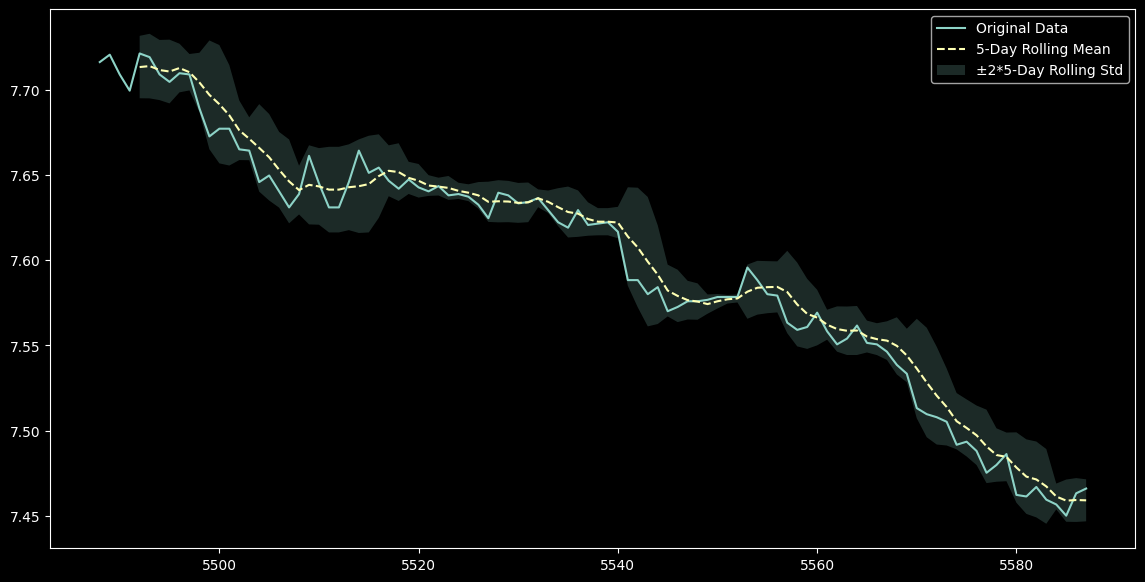

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 假设这是你的原始序列数据
series = np.log(sample)

# 创建画布和轴
fig, ax = plt.subplots(figsize=(14, 7))

# 绘制原始数据
series.plot(ax=ax, label='Original Data')

# 定义要用于均值和标准差的窗口列表
windows = [5]

# 对于每个窗口，计算滚动均值和滚动标准差
for window in windows:
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    
    # 绘制均值
    rolling_mean.plot(ax=ax, linestyle='--', label=f'{window}-Day Rolling Mean')
    # rolling_gap.plot(ax=ax, linestyle='-.', label=f'{window}-Day Rolling Gap')
    
    # 绘制标准差
    ax.fill_between(series.index, 
                   (rolling_mean - 2*rolling_std),
                   (rolling_mean + 2*rolling_std),
                   alpha=0.2, label=f'±2*{window}-Day Rolling Std')
    
# 添加图例
ax.legend()

# 显示图表
plt.show()